# Gender Bias Recruitment - Model Fair

Treinar um modelo com **mitigação de viés**, usando o mesmo dataset do notebook anterior, mas removendo atributos sensíveis e avaliando melhorias em fairness.

Este notebook complementa o *02_model_biased*, permitindo comparar modelo enviesado vs. modelo justo.


## 1. Importação das bibliotecas  

Importamos bibliotecas para:  
- Interação com o sistema de arquivos (`os`, `sys`)
- Manipulação e análise de dados (`pandas`, `numpy`)  
- Visualização (`matplotlib`, `seaborn`)  
- Carregamento de objetos salvos (`pickle`)
- Módulos personalizados do `src/` para pré-processamento, treino e fairness
- Configuração do estilo visual com `sns.set(style="whitegrid")`

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_preprocessing import (
    load_dataset,
    clean_columns,
    encode_categorical,
    split_features_target,
    train_test_split_stratified
)
from fairness_metrics import remove_sensitive_attributes, compute_fairness_metrics
from train_model import train_random_forest, evaluate_model, save_object

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

## 2. Carregar e limpar o dataset

Carregamos o CSV e padronizamos os nomes das colunas para evitar erros.

In [2]:
df = load_dataset("../data/2025-fairness-recruitment-dataset.csv")
df = clean_columns(df)
df.head()

,mainid_hidden,mod15_hidden,div15_hidden,Age_feature_sensitive,Speed_hidden,Gender_feature_sensitive,Strength_hidden,Speedtest_hidden,Lifttest_hidden,testresult_feature,livesnear_feature,Suitability_target,Value-when-hired_hidden,Candidate-loss-when-nothired_hidden,Should-hire_target,Shouldnothire,hired-by-expert,A1_testresult,A2_testresult_30under,A3_Age_Gender_test,A4_postive-dicr
0,225000,0,0,22,2,male,6,1.0,1.0,2.0,0,4,"10,000",5000,1,0,1,1,1,1,1
1,225001,1,0,26,2,male,6,0.5,1.0,1.5,1,4,"10,000",5000,1,0,1,1,1,1,0
2,225002,2,0,28,1,male,6,1.0,1.0,2.0,1,3,"5,000",5000,1,0,1,1,1,1,1
3,225003,3,0,28,1,male,6,0.5,1.0,1.5,1,3,"5,000",5000,1,0,1,1,1,1,0
4,225004,4,0,32,2,male,6,1.0,1.0,2.0,0,4,"10,000",5000,1,0,1,1,1,1,1


## 3. Codificar variáveis categóricas

Transforma variáveis de texto em números usando LabelEncoder.

In [3]:
df_encoded, le_dict = encode_categorical(df)
df_encoded.head()

,mainid_hidden,mod15_hidden,div15_hidden,Age_feature_sensitive,Speed_hidden,Gender_feature_sensitive,Strength_hidden,Speedtest_hidden,Lifttest_hidden,testresult_feature,livesnear_feature,Suitability_target,Value-when-hired_hidden,Candidate-loss-when-nothired_hidden,Should-hire_target,Shouldnothire,hired-by-expert,A1_testresult,A2_testresult_30under,A3_Age_Gender_test,A4_postive-dicr
0,225000,0,0,22,2,1,6,1.0,1.0,2.0,0,4,2,5000,1,0,1,1,1,1,1
1,225001,1,0,26,2,1,6,0.5,1.0,1.5,1,4,2,5000,1,0,1,1,1,1,0
2,225002,2,0,28,1,1,6,1.0,1.0,2.0,1,3,3,5000,1,0,1,1,1,1,1
3,225003,3,0,28,1,1,6,0.5,1.0,1.5,1,3,3,5000,1,0,1,1,1,1,0
4,225004,4,0,32,2,1,6,1.0,1.0,2.0,0,4,2,5000,1,0,1,1,1,1,1


## 4. Remover atributos sensíveis

Aqui aplicamos mitigação simples de viés removendo:
- `Gender`
- `Age`

In [4]:
SENSITIVE_COLS = ["Gender_feature_sensitive", "Age_feature_sensitive"]

sensitive_gender = df_encoded["Gender_feature_sensitive"]
df_fair = remove_sensitive_attributes(df_encoded, SENSITIVE_COLS)
df_fair.head()

,mainid_hidden,mod15_hidden,div15_hidden,Speed_hidden,Strength_hidden,Speedtest_hidden,Lifttest_hidden,testresult_feature,livesnear_feature,Suitability_target,Value-when-hired_hidden,Candidate-loss-when-nothired_hidden,Should-hire_target,Shouldnothire,hired-by-expert,A1_testresult,A2_testresult_30under,A3_Age_Gender_test,A4_postive-dicr
0,225000,0,0,2,6,1.0,1.0,2.0,0,4,2,5000,1,0,1,1,1,1,1
1,225001,1,0,2,6,0.5,1.0,1.5,1,4,2,5000,1,0,1,1,1,1,0
2,225002,2,0,1,6,1.0,1.0,2.0,1,3,3,5000,1,0,1,1,1,1,1
3,225003,3,0,1,6,0.5,1.0,1.5,1,3,3,5000,1,0,1,1,1,1,0
4,225004,4,0,2,6,1.0,1.0,2.0,0,4,2,5000,1,0,1,1,1,1,1


## 5. Separar features e target

Define a coluna‐alvo (`Should-hire_target`) e separa os dados.

In [5]:
target_col = "Should-hire_target"
X, y = split_features_target(df_fair, target_col)

## 6. Dividir em treino e teste

A divisão estratificada mantém a proporção das classes no treino e teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_stratified(X, y)

,mainid_hidden,mod15_hidden,div15_hidden,Speed_hidden,Strength_hidden,Speedtest_hidden,Lifttest_hidden,testresult_feature,livesnear_feature,Suitability_target,Value-when-hired_hidden,Candidate-loss-when-nothired_hidden,Shouldnothire,hired-by-expert,A1_testresult,A2_testresult_30under,A3_Age_Gender_test,A4_postive-dicr
92,225092,2,6,1,5,1.0,1.0,2.0,1,2,1,1000,1,0,1,1,1,1
146,225146,11,9,0,4,0.5,0.0,0.5,1,1,0,10,1,0,0,0,0,0
28,225028,13,1,0,6,0.5,1.0,1.5,1,1,0,10,1,0,1,0,0,1
95,225095,5,6,1,5,1.0,1.0,2.0,0,2,1,1000,1,1,1,1,1,1
73,225073,13,4,0,6,0.5,0.5,1.0,0,1,0,10,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,225203,8,13,0,4,0.0,0.5,0.5,0,1,0,10,1,0,0,0,0,0
72,225072,12,4,0,6,0.5,0.5,1.0,1,1,0,10,1,0,0,0,0,0
76,225076,1,5,2,6,0.5,0.5,1.0,1,4,2,5000,0,1,0,0,1,0
30,225030,0,2,2,6,1.0,1.0,2.0,1,4,2,5000,0,1,1,1,1,1


## 7. Treinar o modelo mitigado

Treinamos um Random Forest sem acesso às variáveis sensíveis.

In [7]:
model_fair = train_random_forest(X_train, y_train)

## 8. Avaliar o modelo (performance geral)

Mostra métricas como acurácia, precisão, recall e matriz de confusão.

In [8]:
y_pred_fair, metrics_fair_general = evaluate_model(model_fair, X_test, y_test)

## 9. Calcular métricas de fairness

Comparamos o desempenho do modelo entre diferentes grupos sensíveis.

In [9]:
sensitive_series_test = sensitive_gender.loc[X_test.index]

df_group_fair, summary_fair = compute_fairness_metrics(
    model=model_fair,
    X=X_test,
    y_true=y_test,
    sensitive_series=sensitive_series_test
)

## 10. Visualização: Taxa de Predição Positiva

Ajuda a identificar possíveis disparidades entre grupos.

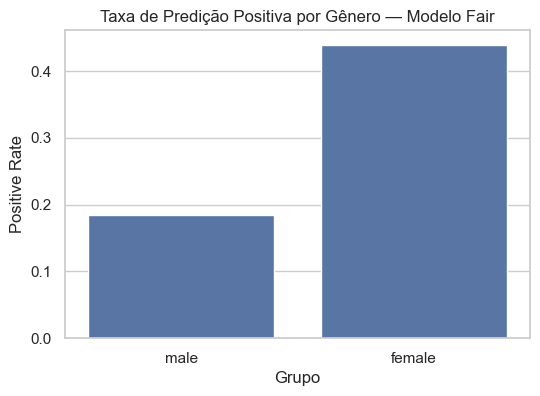

In [16]:
df_group_fair_plot = df_group_fair.reset_index()

df_group_fair_plot['group'] = df_group_fair_plot['group'].map({0: "male", 1: "female"})

plt.figure(figsize=(6,4))
sns.barplot(data=df_group_fair_plot, x="group", y="positive_rate")
plt.title("Taxa de Predição Positiva por Gênero — Modelo Fair")
plt.xlabel("Grupo")
plt.ylabel("Positive Rate")
plt.show()

## 11. Salvando métricas e modelos treinados

Após treinar e avaliar os modelos, salvamos os objetos de métricas e os modelos em arquivos `.pkl`.

In [ ]:
# Salvar métricas gerais
save_object(metrics_fair_general, "metrics_general_rf_fair.pkl")

# Salvar métricas de fairness
save_object(df_group_fair, "metrics_group_rf_fair.pkl")
save_object(summary_fair, "metrics_summary_rf_fair.pkl")

# Salvar modelo treinado
save_object(model_fair, "model_rf_fair.pkl")

## 12. Conclusão do modelo Fair

- A remoção de atributos sensíveis reduz parte do viés.
- O modelo tende a produzir distribuições mais equilibradas entre grupos.
- Os resultados serão comparados no 04_notebook, que avalia Biased vs Fair.